# SETUP

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import pandas as pd

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

headers = requests.utils.default_headers()
headers.update({"User-Agent": "Chrome/51.0.2704.103"})

import sys
sys.path.append('../')

from utils.constants import *
from utils.scraping_class import Scraping

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None

### LOAD FILES

In [2]:
tournaments_2023 = open("../Data/raw_data/tournaments_2023.txt", "r").read().split('\n')
tournaments_2022 = open("../Data/raw_data/tournaments_2022.txt", "r").read().split('\n')
tournaments_2021 = open("../Data/raw_data/tournaments_2021.txt", "r").read().split('\n')
tournaments_2020 = open("../Data/raw_data/tournaments_2020.txt", "r").read().split('\n')
tournaments_2019 = open("../Data/raw_data/tournaments_2019.txt", "r").read().split('\n')
tournaments_list = [tournaments_2023,tournaments_2022,tournaments_2021,tournaments_2020,tournaments_2019]
all_tournaments = []
for tournament in tournaments_list:
    all_tournaments.extend(tournament)


teamDataTable = pd.read_pickle("../Data/raw_data/teamDataTable.pkl")
playerDataTable = pd.read_pickle("../Data/raw_data/playerDataTable.pkl")

matchList = pd.read_pickle("../Data/raw_data/matchList.pkl")
teamMatchList = pd.read_pickle("../Data/raw_data/teamMatchList.pkl")
playerMatchList = pd.read_pickle("../Data/raw_data/playerMatchList.pkl")
matchListFill = pd.read_pickle("../Data/raw_data/matchListFill.pkl")

# SCRAPPING

### PLAYER

In [3]:
playerDataTable = pd.DataFrame()
for year,season in zip(SEASONS_YEAR,SEASONS):
    playerDataTableTemp = pd.DataFrame()
    
    for semester,split in zip(SEASONS_SEMESTER,SEASONS_SPLIT):
        if not (year=='2023' and split=='Summer'):

            playersLink = f'https://gol.gg/players/list/season-{season}/split-{split}/tournament-ALL/'
            page = requests.get(playersLink,headers=headers)
            bs = BeautifulSoup(page.content, 'lxml')
            linhas = bs.select("""a[href*='player-stats']""")
            playersCode = [x['href'].split('/')[2] for x in linhas]

            playerDataTableTemp2 = Scraping.getTable(playersLink)
            playerDataTableTemp2['playerCode'] = playersCode
            #playerDataTableTemp2['Tournament'] = playerDataTableTemp2['playerCode'].apply(lambda x: Scraping.playerTournamentFind(x,season,split))
            playerDataTableTemp2['Semester'] = semester
            playerDataTableTemp2['Split'] = split

            playerDataTableTemp = pd.concat([playerDataTableTemp,playerDataTableTemp2])
            playerDataTableTemp.reset_index(drop=True,inplace=True)
            
    playerDataTableTemp['Year'] = year
    playerDataTable = pd.concat([playerDataTable,playerDataTableTemp])
    playerDataTable.reset_index(drop=True,inplace=True)

### MATCHES

In [5]:
matchList = pd.DataFrame()
for tournament in all_tournaments:
    page = requests.get(f'https://gol.gg/tournament/tournament-matchlist/{tournament}/',headers=headers)
    bs = BeautifulSoup(page.content, 'lxml')
    linhas = bs.select("""a[href*='game/stats/']""")
    gameCodesPre = [x['href'].split('/')[3] for x in linhas]

    matchListTemp = Scraping.getTable(f'https://gol.gg/tournament/tournament-matchlist/{tournament}/')
    if len(matchListTemp)>0:
        matchListTemp = matchListTemp[matchListTemp['Score'].str.contains('FF') == False]
        matchListTemp['matchCodePre'] = gameCodesPre
        matchListTemp['Tournament'] = tournament
        matchListTemp.dropna(inplace=True)
        matchList = pd.concat([matchList,matchListTemp])
    
matchList = (matchList.drop(['Game','Unnamed: 4','Patch'],axis=1)
                    .rename(columns={'Unnamed: 1':'Blue','Unnamed: 3':'Red'})
                    .reset_index(drop=True))

KeyboardInterrupt: 

In [ ]:

gameCodes=[]
matchList[ROLE_SIDE_COLS] = 'sNaN'
for i in range(len(matchList)):
    code = matchList['matchCodePre'][i]
    
    page = requests.get(f'https://gol.gg/game/stats/{code}/page-summary/',headers=headers)
    bs = BeautifulSoup(page.content, 'lxml')
    linhas = bs.select("""a[href*='page-game']""")
    gameCodesSummary = [x['href'].split('/')[3] for x in linhas]
    gameCodes.append(gameCodesSummary)
    
    tables = pd.read_html(page.text)
    blueNames = (tables[0])['Player']
    redNames = (tables[1])['Player']
    allNames = list(blueNames)
    allNames.extend(list(redNames))
    
    for name,val in zip(ROLE_SIDE_COLS,allNames):
        matchList[name][i] = val

matchList['matchCode'] = gameCodes
matchList = matchList.explode('matchCode')
matchList.reset_index(drop=True,inplace=True)

Wall time: 9h 31min 20s


### TEAMS

In [ ]:
teamDataTable = pd.DataFrame()
for year,season in zip(SEASONS_YEAR,SEASONS):

    teamDataTableTemp = pd.DataFrame()
    for semester,split in zip(SEASONS_SEMESTER,SEASONS_SPLIT):
        if not(year=='2023' and split=='Summer'):

            teamsLink = f'https://gol.gg/teams/list/season-{season}/split-{split}/tournament-ALL/'
            page = requests.get(teamsLink,headers=headers)
            bs = BeautifulSoup(page.content, 'lxml')
            linhas = bs.select("""a[href*='team-stats']""")
            teamsCode = [x['href'].split('/')[2] for x in linhas]

            teamDataTableTemp2 = Scraping.getTable(teamsLink)
            teamDataTableTemp2['teamCode'] = teamsCode
            #teamDataTableTemp2['Tournament'] = teamDataTableTemp2['teamCode'].apply(lambda x: Scraping.teamTournamentFind(x,split))
            teamDataTableTemp2['Semester'] = semester
            teamDataTableTemp2['Split'] = split

            teamDataTableTemp = pd.concat([teamDataTableTemp,teamDataTableTemp2])
            teamDataTableTemp.reset_index(drop=True,inplace=True)
    
    teamDataTableTemp['Year'] = year
    teamDataTable = pd.concat([teamDataTable,teamDataTableTemp])
    teamDataTable.reset_index(drop=True,inplace=True)

Wall time: 30.7 s


# PROCESSING

### PLAYER

In [ ]:
for col in playerDataTable:
    playerDataTable[col] = playerDataTable[col].apply(lambda x: str(x).replace('%',''))
    playerDataTable[col] = playerDataTable[col].apply(lambda x: np.nan if ('-' in x and len(x)<2) else x )

playerDataTable[PLAYER_FLOAT_COLS] = playerDataTable[PLAYER_FLOAT_COLS].astype(float)
playerDataTable[PLAYER_INT_COLS] = playerDataTable[PLAYER_INT_COLS].fillna(0).astype(int)
playerDataTable.columns = [x.replace(' ','_') for x in playerDataTable.columns]

Wall time: 212 ms


### TEAM

In [ ]:
for col in teamDataTable:
    teamDataTable[col] = teamDataTable[col].apply(lambda x: str(x).replace('%',''))
    teamDataTable[col] = teamDataTable[col].apply(lambda x: np.nan if ('-' in x and len(x)<2) else x )

teamDataTable[TEAM_FLOAT_COLS] = teamDataTable[TEAM_FLOAT_COLS].astype(float)
teamDataTable[TEAM_INT_COLS] = teamDataTable[TEAM_INT_COLS].fillna(0).astype(int)

teamDataTable['Game duration'] = pd.to_datetime(teamDataTable['Game duration'], format='%H:%M:%S').dt.time
teamDataTable.columns = [x.replace(' ','_') for x in teamDataTable.columns]

KeyError: "['TOP', 'JNG', 'MID', 'ADC', 'SUP'] not in index"

In [ ]:
teamDataTable[ROLES] = 'sNaN'
for i in range(len(teamDataTable)):
    
    code = teamDataTable['teamCode'][i]
    split = teamDataTable['Split'][i]
    page = requests.get(f'https://gol.gg/teams/team-stats/{code}/split-{split}/tournament-ALL/',headers=headers)
    tables = pd.read_html(page.text)[-1]
    
    allNames = tables['Player'][1:6]
    for name,val in zip(ROLES,allNames):
        teamDataTable[name][i] = val

Wall time: 51min 24s


### MATCH

In [ ]:
matchList['StatsTemp'] = matchList['matchCode'].apply(lambda x: Scraping.getMatchStats(x))
matchList['blueKills'] = matchList['StatsTemp'].apply(lambda x: x[0])
matchList['redKills'] = matchList['StatsTemp'].apply(lambda x: x[1])
matchList['totalKills'] = matchList['StatsTemp'].apply(lambda x: x[2])

matchListToDrop=['StatsTemp','matchCodePre']
for col in matchListToDrop:
    matchList.drop(col, axis=1, errors='ignore', inplace=True)

matchList['Score'] = matchList['Score'].apply(lambda x: Scraping.scoreSelect(x))

Wall time: 13h 44min 6s


# FEATURE ENGINEERING

### SEASON DATA SWAP

In [119]:
if 'realYear' not in matchList.columns:
    matchList['Date'] = matchList['Date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))
    matchList['Semester'] = matchList['Date'].apply(lambda x: 0 if x.month <= 6 else 1)
    matchList['Split'] = matchList['Date'].apply(lambda x: 'Spring' if x.month <= 6 else 'Summer')
    matchList['Year'] = matchList['Date'].apply(lambda x: x.year)

    matchList['regionAbrev'] = matchList['Tournament'].apply(lambda x: Scraping.findRegionTournament(x))

    matchList['realSemester'] = matchList['Semester']
    matchList['realYear'] = matchList['Year']

    matchList['Semester'] = matchList['Semester'].apply(lambda x: 0 if x==1 else 1)
    matchList['Year'] = matchList['Year'] - matchList['Semester']

    matchList['realSemesterYear'] = (matchList['realYear'].astype(str)
                                    + matchList['realSemester'].astype(str))
    
    matchList['semesterYear'] = (matchList['Year'].astype(str)
                                + matchList['Semester'].astype(str))

    matchList['tournamentId'] = (matchList['regionAbrev'].astype(str)
                                + matchList['realSemesterYear'].astype(str))

for role in ROLE_SIDE_COLS:
    if (role+'_'+PLAYER_SIMPLE_FEATURE_COLS[0] not in matchList.columns):
        
        playerDataCols = ['Player','Year','Semester']
        
        playerDataTableMerge = playerDataTable[playerDataCols+PLAYER_SIMPLE_FEATURE_COLS]
        matchList = pd.merge(matchList,
                              playerDataTableMerge,
                              how='left',
                              left_on=[role,'Year','Semester'],
                              right_on=['Player','Year','Semester'])

        renameCols = PLAYER_SIMPLE_FEATURE_COLS.copy()
        renameCols.append('Player')
        renameCols = [role+'_'+x for x in renameCols]
        renameDict = dict(zip(PLAYER_SIMPLE_FEATURE_COLS+['Player'], renameCols))
        matchList = matchList.rename(columns=renameDict)
        matchList.drop([role+'_Player'],axis=1,inplace=True)
    else: print(f'{role} skipped')

TOP_Blue skipped
JNG_Blue skipped
MID_Blue skipped
ADC_Blue skipped
SUP_Blue skipped
TOP_Red skipped
JNG_Red skipped
MID_Red skipped
ADC_Red skipped
SUP_Red skipped
CPU times: total: 46.9 ms
Wall time: 44 ms


### FILL NULL VALUES

In [172]:
def fillFeatureTeam(index,role,feature,side):
    value = matchListFill[role+'_'+feature][index]
    
    if np.isnan(value):
        roleSide = [x for x in ROLE_SIDE_COLS if side in x]
        columnsToMean = [col+'_'+feature for col in roleSide]
        listToMean = matchListFill[columnsToMean].loc[index].dropna()
        newValue = np.mean(listToMean)
        
        return newValue
    else:
        return value
    
def fillFeaturePlayer(df,index,role_side_feature,feature,side):
    value = df[role_side_feature][index]
    name = df[role+'_'+side][index]
    year = df['Year'][index]
    semester = df['Semester'][index]
    
    if np.isnan(value):
        playerDfFilter = (playerDataTable[playerDataTable['Player']==name])[['Player','Semester','Year',feature]]
        if semester==0:
            playerDfFilter = playerDfFilter[(playerDfFilter['Year']<=year) 
                                            & ((playerDfFilter['Year']>=year-1)
                                              & (playerDfFilter['Semester']==1))]
        else:
            playerDfFilter = playerDfFilter[(playerDfFilter['Year']>=year) 
                                            & ((playerDfFilter['Year']<=year+1)
                                              & (playerDfFilter['Semester']==0))]
        newValue = np.mean(playerDfFilter[feature].tail(3))
        if not np.isnan(newValue):
            cont.append(0)
        print(f'nan vals removed: {len(cont)} index number: {round(index/len(df)*100,2)}%',end='\r')
            
        return newValue
    else:
        return value

In [173]:
cont = []

matchListFill = matchList.reset_index().copy()
matchListFill.reset_index(drop=True,inplace=True)
matchListFill.columns = [x.replace(' ','_') for x in matchListFill.columns]
oldNanSum = sum(matchListFill.isna().sum())

playerDataTable.columns = [x.replace(' ','_') for x in playerDataTable.columns]

for feature in PLAYER_SIMPLE_FEATURE_COLS:
    for role_side in ROLE_SIDE_COLS:
        print('\n',role_side+'_'+feature)
        side = role_side.split('_')[1]
        role = role_side.split('_')[0]
        role_side_feature = role_side+'_'+feature
        
        print(f'\nold nan cont: {matchListFill[role_side_feature].isna().sum()}')
        matchListFill[role_side_feature] = matchListFill['index'].apply(lambda indexl: fillFeaturePlayer(matchListFill
                                                                                                        ,indexl
                                                                                                        ,role_side_feature
                                                                                                        ,feature
                                                                                                        ,side))
        print(f'\nnew nan cont: {matchListFill[role_side_feature].isna().sum()}')
        newNanSum = sum(matchListFill.isna().sum())
        print(f'\nold nan sum: {oldNanSum}, new nan sum: {newNanSum}, diff: {oldNanSum-newNanSum}')
        
matchListFill.drop('index',inplace=True,axis=1)

for col in matchListFill.columns:
                matchListFill[col] = matchListFill[col].fillna(0)


 TOP_Blue_Games

old nan cont: 9744
nan vals removed: 9162 index number: 100.0%
new nan cont: 582

old nan sum: 2220312, new nan sum: 2211150, diff: 9162

 JNG_Blue_Games

old nan cont: 9962
nan vals removed: 18494 index number: 100.0%
new nan cont: 630

old nan sum: 2220312, new nan sum: 2201818, diff: 18494

 MID_Blue_Games

old nan cont: 9361
nan vals removed: 27084 index number: 100.0%
new nan cont: 771

old nan sum: 2220312, new nan sum: 2193228, diff: 27084

 ADC_Blue_Games

old nan cont: 9741
nan vals removed: 36199 index number: 100.0%
new nan cont: 626

old nan sum: 2220312, new nan sum: 2184113, diff: 36199

 SUP_Blue_Games

old nan cont: 9703
nan vals removed: 45273 index number: 100.0%
new nan cont: 629

old nan sum: 2220312, new nan sum: 2175039, diff: 45273

 TOP_Red_Games

old nan cont: 9988
nan vals removed: 54694 index number: 100.0%
new nan cont: 567

old nan sum: 2220312, new nan sum: 2165618, diff: 54694

 JNG_Red_Games

old nan cont: 10186
nan vals removed: 64329 

nan vals removed: 489074 index number: 100.0%
new nan cont: 771

old nan sum: 2220312, new nan sum: 1731238, diff: 489074

 ADC_Blue_XPD@15

old nan cont: 9741
nan vals removed: 498189 index number: 100.0%
new nan cont: 626

old nan sum: 2220312, new nan sum: 1722123, diff: 498189

 SUP_Blue_XPD@15

old nan cont: 9703
nan vals removed: 507263 index number: 100.0%
new nan cont: 629

old nan sum: 2220312, new nan sum: 1713049, diff: 507263

 TOP_Red_XPD@15

old nan cont: 9988
nan vals removed: 516684 index number: 100.0%
new nan cont: 567

old nan sum: 2220312, new nan sum: 1703628, diff: 516684

 JNG_Red_XPD@15

old nan cont: 10186
nan vals removed: 526319 index number: 100.0%
new nan cont: 551

old nan sum: 2220312, new nan sum: 1693993, diff: 526319

 MID_Red_XPD@15

old nan cont: 9756
nan vals removed: 535518 index number: 100.0%
new nan cont: 557

old nan sum: 2220312, new nan sum: 1684794, diff: 535518

 ADC_Red_XPD@15

old nan cont: 9993
nan vals removed: 544956 index number: 100.

nan vals removed: 960352 index number: 100.0%
new nan cont: 626

old nan sum: 2220312, new nan sum: 1259960, diff: 960352

 SUP_Blue_Avg_kills

old nan cont: 9703
nan vals removed: 969426 index number: 100.0%
new nan cont: 629

old nan sum: 2220312, new nan sum: 1250886, diff: 969426

 TOP_Red_Avg_kills

old nan cont: 9988
nan vals removed: 978847 index number: 100.0%
new nan cont: 567

old nan sum: 2220312, new nan sum: 1241465, diff: 978847

 JNG_Red_Avg_kills

old nan cont: 10186
nan vals removed: 988482 index number: 100.0%
new nan cont: 551

old nan sum: 2220312, new nan sum: 1231830, diff: 988482

 MID_Red_Avg_kills

old nan cont: 9756
nan vals removed: 997681 index number: 100.0%
new nan cont: 557

old nan sum: 2220312, new nan sum: 1222631, diff: 997681

 ADC_Red_Avg_kills

old nan cont: 9993
nan vals removed: 1007119 index number: 100.0%
new nan cont: 555

old nan sum: 2220312, new nan sum: 1213193, diff: 1007119

 SUP_Red_Avg_kills

old nan cont: 9993
nan vals removed: 101655

nan vals removed: 1431418 index number: 100.0%
new nan cont: 629

old nan sum: 2220312, new nan sum: 788894, diff: 1431418

 TOP_Red_DMG%

old nan cont: 9988
nan vals removed: 1440839 index number: 100.0%
new nan cont: 567

old nan sum: 2220312, new nan sum: 779473, diff: 1440839

 JNG_Red_DMG%

old nan cont: 10186
nan vals removed: 1450474 index number: 100.0%
new nan cont: 551

old nan sum: 2220312, new nan sum: 769838, diff: 1450474

 MID_Red_DMG%

old nan cont: 9759
nan vals removed: 1459676 index number: 100.0%
new nan cont: 557

old nan sum: 2220312, new nan sum: 760636, diff: 1459676

 ADC_Red_DMG%

old nan cont: 9996
nan vals removed: 1469117 index number: 100.0%
new nan cont: 555

old nan sum: 2220312, new nan sum: 751195, diff: 1469117

 SUP_Red_DMG%

old nan cont: 9993
nan vals removed: 1478549 index number: 100.0%
new nan cont: 561

old nan sum: 2220312, new nan sum: 741763, diff: 1478549

 TOP_Blue_VSPM

old nan cont: 11210
nan vals removed: 1487797 index number: 100.0%
ne

nan vals removed: 1911619 index number: 100.0%
new nan cont: 1610

old nan sum: 2220312, new nan sum: 308693, diff: 1911619

 JNG_Red_FB_%

old nan cont: 11451
nan vals removed: 1921520 index number: 100.0%
new nan cont: 1550

old nan sum: 2220312, new nan sum: 298792, diff: 1921520

 MID_Red_FB_%

old nan cont: 11088
nan vals removed: 1931084 index number: 100.0%
new nan cont: 1524

old nan sum: 2220312, new nan sum: 289228, diff: 1931084

 ADC_Red_FB_%

old nan cont: 11211
nan vals removed: 1940730 index number: 100.0%
new nan cont: 1565

old nan sum: 2220312, new nan sum: 279582, diff: 1940730

 SUP_Red_FB_%

old nan cont: 11323
nan vals removed: 1950481 index number: 100.0%
new nan cont: 1572

old nan sum: 2220312, new nan sum: 269831, diff: 1950481

 TOP_Blue_FB_Victim

old nan cont: 11077
nan vals removed: 1959887 index number: 100.0%
new nan cont: 1671

old nan sum: 2220312, new nan sum: 260425, diff: 1959887

 JNG_Blue_FB_Victim

old nan cont: 11237
nan vals removed: 1969514 in

# SAVE FILES

In [224]:
playerDataTable.to_pickle("../Data/raw_data/playerDataTable.pkl")
teamDataTable.to_pickle("../Data/raw_data/teamDataTable.pkl")

matchList.to_pickle("../Data/raw_data/matchList.pkl")
matchListFill.to_pickle("../Data/raw_data/matchListFill.pkl")

# Notes

In [181]:
playerDataTable.describe()

,Games,Win_rate,KDA,Avg_kills,Avg_deaths,Avg_assists,CSM,GPM,KP%,DMG%,DPM,VSPM,Avg_WPM,Avg_WCPM,Avg_VWPM,GD@15,CSD@15,XPD@15,FB_%,FB_Victim,Penta_Kills,Solo_Kills,Semester,Year
count,13123.000000,13123.000000,13108.000000,13123.000000,13123.000000,13123.000000,13123.000000,13123.000000,13123.000000,13121.000000,13123.000000,12425.000000,12812.000000,12812.000000,12812.000000,13123.000000,13123.000000,13123.000000,12490.000000,12490.000000,13123.000000,13123.000000,13123.000000,13123.000000
mean,22.125657,44.127799,3.272330,2.559918,2.888478,5.889263,6.222350,348.635449,64.000587,19.724198,381.805989,1.420299,0.615101,0.270174,0.245624,-79.775356,-1.184180,-49.290101,23.246773,10.249752,0.035967,3.675913,0.449288,2020.918007
std,13.838768,21.213997,1.584695,1.353688,0.914306,2.057960,2.846278,68.293654,9.306458,7.458566,155.568079,0.599563,0.418568,0.106207,0.129656,416.075750,8.561031,314.729115,15.003662,10.410995,0.207140,5.031380,0.497441,1.283588
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.700000,0.000000,0.220000,0.000000,0.000000,0.000000,-4452.000000,-148.000000,-3840.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000
25%,14.000000,31.300000,2.300000,1.500000,2.300000,4.500000,4.900000,308.000000,59.000000,13.500000,249.000000,1.000000,0.370000,0.180000,0.150000,-260.000000,-5.000000,-199.000000,13.800000,3.600000,0.000000,0.000000,0.000000,2020.000000
50%,20.000000,46.700000,3.100000,2.600000,2.800000,5.600000,7.400000,363.000000,65.300000,21.600000,401.000000,1.200000,0.440000,0.260000,0.210000,-27.000000,0.000000,-10.000000,22.200000,8.700000,0.000000,2.000000,0.000000,2021.000000
75%,30.000000,58.800000,4.000000,3.500000,3.400000,7.000000,8.400000,400.000000,70.000000,25.800000,502.000000,1.630000,0.600000,0.340000,0.330000,142.000000,3.000000,126.000000,31.800000,14.300000,0.000000,5.000000,1.000000,2022.000000
max,85.000000,100.000000,31.800000,15.000000,10.000000,20.000000,10.800000,590.000000,100.000000,42.800000,1372.000000,4.290000,2.640000,0.950000,1.200000,2685.000000,72.000000,2692.000000,100.000000,100.000000,4.000000,56.000000,1.000000,2023.000000


In [182]:
teamDataTable.describe()

,Games,K:D,GPM,GDM,Kills / game,Deaths / game,Towers killed,Towers lost,FB%,FT%,DRAPG,DRA%,HERPG,HER%,DRA@15,TD@15,GD@15,PPG,NASHPG,NASH%,CSM,DPM
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2168.000000,2157.000000,2203.000000,2203.000000,2108.000000,2106.000000,2108.000000,2108.000000,2148.000000,813.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,26.459374,0.986668,1761.545166,-31.586473,13.205402,14.040899,5.703450,6.287653,49.116882,47.661799,2.208983,48.301952,0.860769,48.465195,0.871746,-0.075237,-209.574488,4.384563,0.648407,46.929006,31.502951,1951.907853
std,13.044344,0.311002,86.995162,159.753159,2.665958,2.922707,1.505508,1.455439,12.598821,15.985495,0.490554,10.841339,0.313345,13.952926,0.240170,0.505700,1271.392815,1.054903,0.223736,16.294452,1.387918,235.839342
min,2.000000,0.080000,1354.000000,-842.000000,1.500000,4.300000,0.000000,1.500000,2.200000,2.200000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.500000,-11005.000000,1.300000,0.000000,0.000000,21.100000,1023.000000
25%,18.000000,0.780000,1706.000000,-127.000000,11.500000,12.100000,4.800000,5.300000,41.700000,37.100000,1.940000,41.900000,0.637500,39.500000,0.710000,-0.300000,-886.250000,3.680000,0.500000,36.600000,30.700000,1793.000000
50%,23.000000,0.960000,1767.000000,-18.000000,13.300000,13.700000,5.900000,6.200000,50.000000,48.000000,2.260000,48.900000,0.900000,50.000000,0.880000,0.000000,-79.000000,4.400000,0.670000,48.200000,31.600000,1938.000000
75%,34.000000,1.165000,1820.000000,77.000000,15.000000,15.700000,6.800000,7.300000,57.100000,58.600000,2.530000,55.400000,1.090000,57.300000,1.030000,0.200000,565.250000,5.000000,0.800000,58.300000,32.400000,2102.500000
max,85.000000,3.210000,2099.000000,452.000000,23.400000,28.700000,9.800000,11.000000,100.000000,100.000000,4.330000,94.400000,2.000000,100.000000,2.000000,1.800000,4081.000000,10.500000,1.500000,100.000000,41.100000,3089.000000


In [183]:
teamMatchList.describe()

,Score,blueKills,redKills,totalKills,Semester,Year,realSemester,realYear,Team_Blue_Win_rate,Team_Blue_KDA,Team_Blue_Avg_kills,Team_Blue_Avg_deaths,Team_Blue_Avg_assists,Team_Blue_CSM,Team_Blue_KP%,Team_Blue_DMG%,Team_Blue_VSPM,Team_Blue_Avg_WPM,Team_Blue_Avg_WCPM,Team_Blue_Avg_VWPM,Team_Blue_FB_%,Team_Blue_FB_Victim,Team_Blue_GPM,Team_Blue_DPM,Team_Blue_GD@15,Team_Blue_CSD@15,Team_Blue_XPD@15,Team_Blue_Games,Team_Blue_Penta_Kills,Team_Blue_Solo_Kills,Team_Red_Win_rate,Team_Red_KDA,Team_Red_Avg_kills,Team_Red_Avg_deaths,Team_Red_Avg_assists,Team_Red_CSM,Team_Red_KP%,Team_Red_DMG%,Team_Red_VSPM,Team_Red_Avg_WPM,Team_Red_Avg_WCPM,Team_Red_Avg_VWPM,Team_Red_FB_%,Team_Red_FB_Victim,Team_Red_GPM,Team_Red_DPM,Team_Red_GD@15,Team_Red_CSD@15,Team_Red_XPD@15,Team_Red_Games,Team_Red_Penta_Kills,Team_Red_Solo_Kills
count,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.00000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.00000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000
mean,0.484769,13.920586,13.331351,27.251937,0.608264,2020.530653,0.391736,2021.138917,49.194846,3.606462,2.871154,2.669683,5.949608,6.839904,64.732620,21.443121,1.305956,0.589761,0.263895,0.234763,22.171616,8.953890,364.755000,413.448905,0.255066,-0.029300,0.490633,140.884792,0.253012,25.981758,49.897295,3.661404,2.906479,2.64212,5.969886,6.882795,64.856054,21.570778,1.309622,0.587380,0.263273,0.234467,22.193334,8.964632,366.175271,416.695702,12.98325,0.220921,7.022969,141.557649,0.251208,26.578474
std,0.524060,7.037772,7.283166,8.901517,0.488148,1.058032,0.488148,1.129619,13.743706,0.960965,0.573684,0.513322,1.025378,0.750883,4.003967,2.380706,0.313641,0.136410,0.061751,0.054497,8.654125,4.667059,19.899506,57.040538,225.208155,4.418053,160.641676,62.795574,0.584928,17.609094,12.486325,0.894140,0.581803,0.47529,0.960789,0.798657,3.828178,2.485956,0.292724,0.136427,0.059910,0.053967,8.310627,4.542043,21.103016,59.552576,202.16214,4.047533,147.365559,59.705085,0.584032,18.013099
min,0.000000,0.000000,0.000000,3.000000,0.000000,2019.000000,0.000000,2019.000000,0.000000,0.100000,0.000000,0.500000,0.000000,0.500000,16.700000,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,196.000000,96.000000,-2005.000000,-39.000000,-1483.000000,1.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.50000,0.300000,0.800000,20.020000,5.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,211.000000,103.000000,-2814.00000,-57.000000,-2107.000000,1.000000,0.000000,0.000000
25%,0.000000,8.000000,7.000000,21.000000,0.000000,2020.000000,0.000000,2020.000000,41.660000,3.000000,2.500000,2.340000,5.320000,6.360000,62.720000,19.980000,1.182000,0.500000,0.230000,0.205000,18.220000,6.620000,352.600000,376.600000,-96.300000,-2.000000,-72.000000,97.500000,0.000000,14.000000,42.860000,3.100000,2.533333,2.33000,5.350000,6.360000,62.880000,20.000000,1.172000,0.489000,0.229000,0.204000,18.290000,6.540000,353.200000,378.000000,-85.47500,-1.800000,-65.200000,100.000000,0.000000,15.000000
50%,0.000000,14.000000,13.000000,26.000000,1.000000,2021.000000,0.000000,2021.000000,50.280000,3.540000,2.860000,2.640000,6.010000,6.620000,65.200000,20.740000,1.376000,0.622000,0.268000,0.242000,23.100000,8.860000,363.600000,407.400000,15.600000,0.200000,10.400000,128.000000,0.000000,23.500000,50.520000,3.600000,2.880000,2.62000,6.010000,6.640000,65.220000,20.840000,1.368000,0.620000,0.266000,0.240000,23.080000,8.900000,364.400000,409.800000,19.80000,0.400000,11.000000,129.000000,0.000000,24.00

In [184]:
playerMatchList.describe()

,Score,blueKills,redKills,totalKills,Semester,Year,realSemester,realYear,TOP_Blue_Win_rate,TOP_Blue_KDA,TOP_Blue_Avg_kills,TOP_Blue_Avg_deaths,TOP_Blue_Avg_assists,TOP_Blue_CSM,TOP_Blue_KP%,TOP_Blue_DMG%,TOP_Blue_VSPM,TOP_Blue_Avg_WPM,TOP_Blue_Avg_WCPM,TOP_Blue_Avg_VWPM,TOP_Blue_FB_%,TOP_Blue_FB_Victim,TOP_Blue_Games,TOP_Blue_GPM,TOP_Blue_DPM,TOP_Blue_GD@15,TOP_Blue_CSD@15,TOP_Blue_XPD@15,TOP_Blue_Penta_Kills,TOP_Blue_Solo_Kills,JNG_Blue_Win_rate,JNG_Blue_KDA,JNG_Blue_Avg_kills,JNG_Blue_Avg_deaths,JNG_Blue_Avg_assists,JNG_Blue_CSM,JNG_Blue_KP%,JNG_Blue_DMG%,JNG_Blue_VSPM,JNG_Blue_Avg_WPM,JNG_Blue_Avg_WCPM,JNG_Blue_Avg_VWPM,JNG_Blue_FB_%,JNG_Blue_FB_Victim,JNG_Blue_Games,JNG_Blue_GPM,JNG_Blue_DPM,JNG_Blue_GD@15,JNG_Blue_CSD@15,JNG_Blue_XPD@15,JNG_Blue_Penta_Kills,JNG_Blue_Solo_Kills,MID_Blue_Win_rate,MID_Blue_KDA,MID_Blue_Avg_kills,MID_Blue_Avg_deaths,MID_Blue_Avg_assists,MID_Blue_CSM,MID_Blue_KP%,MID_Blue_DMG%,MID_Blue_VSPM,MID_Blue_Avg_WPM,MID_Blue_Avg_WCPM,MID_Blue_Avg_VWPM,MID_Blue_FB_%,MID_Blue_FB_Victim,MID_Blue_Games,MID_Blue_GPM,MID_Blue_DPM,MID_Blue_GD@15,MID_Blue_CSD@15,MID_Blue_XPD@15,MID_Blue_Penta_Kills,MID_Blue_Solo_Kills,ADC_Blue_Win_rate,ADC_Blue_KDA,ADC_Blue_Avg_kills,ADC_Blue_Avg_deaths,ADC_Blue_Avg_assists,ADC_Blue_CSM,ADC_Blue_KP%,ADC_Blue_DMG%,ADC_Blue_VSPM,ADC_Blue_Avg_WPM,ADC_Blue_Avg_WCPM,ADC_Blue_Avg_VWPM,ADC_Blue_FB_%,ADC_Blue_FB_Victim,ADC_Blue_Games,ADC_Blue_GPM,ADC_Blue_DPM,ADC_Blue_GD@15,ADC_Blue_CSD@15,ADC_Blue_XPD@15,ADC_Blue_Penta_Kills,ADC_Blue_Solo_Kills,SUP_Blue_Win_rate,SUP_Blue_KDA,SUP_Blue_Avg_kills,SUP_Blue_Avg_deaths,SUP_Blue_Avg_assists,SUP_Blue_CSM,SUP_Blue_KP%,SUP_Blue_DMG%,SUP_Blue_VSPM,SUP_Blue_Avg_WPM,SUP_Blue_Avg_WCPM,SUP_Blue_Avg_VWPM,SUP_Blue_FB_%,SUP_Blue_FB_Victim,SUP_Blue_Games,SUP_Blue_GPM,SUP_Blue_DPM,SUP_Blue_GD@15,SUP_Blue_CSD@15,SUP_Blue_XPD@15,SUP_Blue_Penta_Kills,SUP_Blue_Solo_Kills,TOP_Red_Win_rate,TOP_Red_KDA,TOP_Red_Avg_kills,TOP_Red_Avg_deaths,TOP_Red_Avg_assists,TOP_Red_CSM,TOP_Red_KP%,TOP_Red_DMG%,TOP_Red_VSPM,TOP_Red_Avg_WPM,TOP_Red_Avg_WCPM,TOP_Red_Avg_VWPM,TOP_Red_FB_%,TOP_Red_FB_Victim,TOP_Red_Games,TOP_Red_GPM,TOP_Red_DPM,TOP_Red_GD@15,TOP_Red_CSD@15,TOP_Red_XPD@15,TOP_Red_Penta_Kills,TOP_Red_Solo_Kills,JNG_Red_Win_rate,JNG_Red_KDA,JNG_Red_Avg_kills,JNG_Red_Avg_deaths,JNG_Red_Avg_assists,JNG_Red_CSM,JNG_Red_KP%,JNG_Red_DMG%,JNG_Red_VSPM,JNG_Red_Avg_WPM,JNG_Red_Avg_WCPM,JNG_Red_Avg_VWPM,JNG_Red_FB_%,JNG_Red_FB_Victim,JNG_Red_Games,JNG_Red_GPM,JNG_Red_DPM,JNG_Red_GD@15,JNG_Red_CSD@15,JNG_Red_XPD@15,JNG_Red_Penta_Kills,JNG_Red_Solo_Kills,MID_Red_Win_rate,MID_Red_KDA,MID_Red_Avg_kills,MID_Red_Avg_deaths,MID_Red_Avg_assists,MID_Red_CSM,MID_Red_KP%,MID_Red_DMG%,MID_Red_VSPM,MID_Red_Avg_WPM,MID_Red_Avg_WCPM,MID_Red_Avg_VWPM,MID_Red_FB_%,MID_Red_FB_Victim,MID_Red_Games,MID_Red_GPM,MID_Red_DPM,MID_Red_GD@15,MID_Red_CSD@15,MID_Red_XPD@15,MID_Red_Penta_Kills,MID_Red_Solo_Kills,ADC_Red_Win_rate,ADC_Red_KDA,ADC_Red_Avg_kills,ADC_Red_Avg_deaths,ADC_Red_Avg_assists,ADC_Red_CSM,ADC_Red_KP%,ADC_Red_DMG%,ADC_Red_VSPM,ADC_Red_Avg_WPM,ADC_Red_Avg_WCPM,ADC_Red_Avg_VWPM,ADC_Red_FB_%,ADC_Red_FB_Victim,ADC_Red_Games,ADC_Red_GPM,ADC_Red_DPM,ADC_Red_GD@15,ADC_Red_CSD@15,ADC_Red_XPD@15,ADC_Red_Penta_Kills,ADC_Red_Solo_Kills,SUP_Red_Win_rate,SUP_Red_KDA,SUP_Red_Avg_kills,SUP_Red_Avg_deaths,SUP_Red_Avg_assists,SUP_Red_CSM,SUP_Red_KP%,SUP_Red_DMG%,SUP_Red_VSPM,SUP_Red_Avg_WPM,SUP_Red_Avg_WCPM,SUP_Red_Avg_VWPM,SUP_Red_FB_%,SUP_Red_FB_Victim,SUP_Red_Games,SUP_Red_GPM,SUP_Red_DPM,SUP_Red_GD@15,SUP_Red_CSD@15,SUP_Red_XPD@15,SUP_Red_Penta_Kills,SUP_Red_Solo_Kills
count,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26314.000000,26

C:\Users\User\AppData\Local\Temp\ipykernel_12592\713525128.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 5))


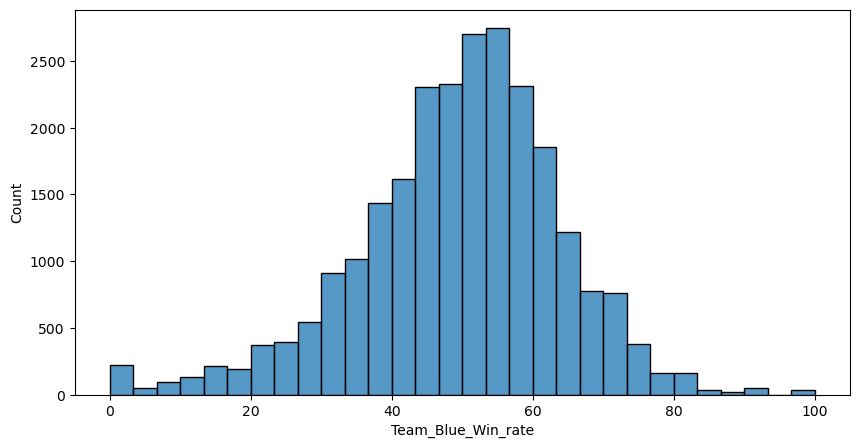

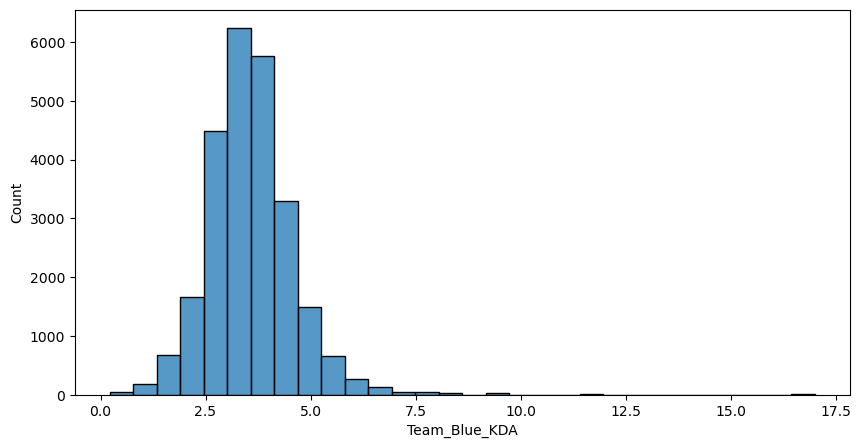

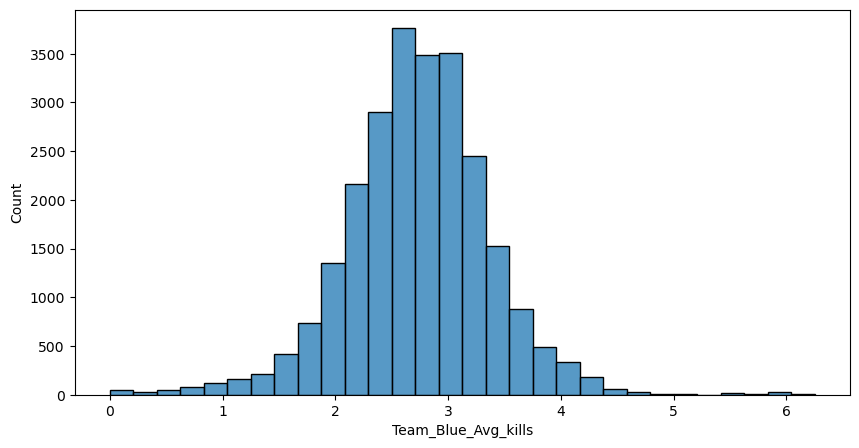

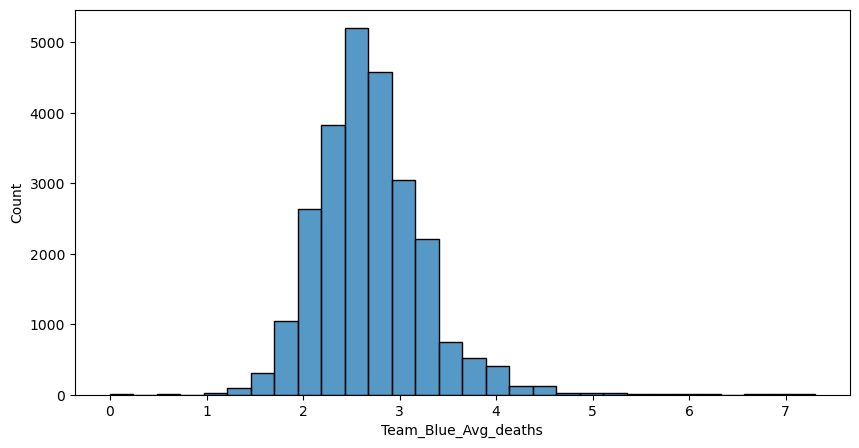

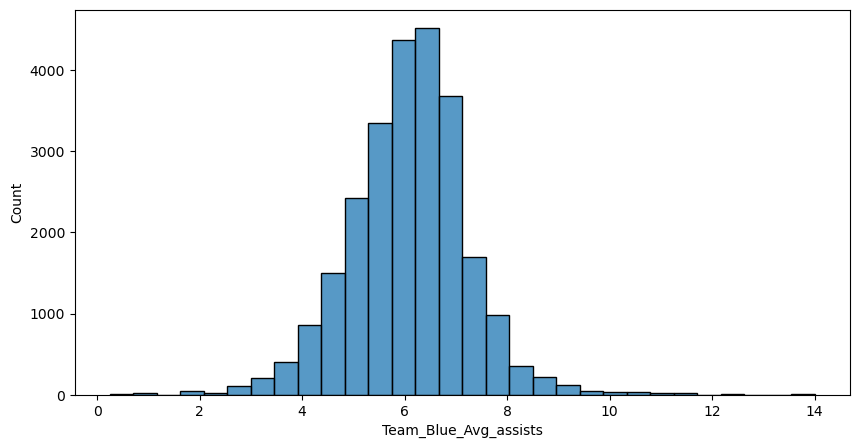

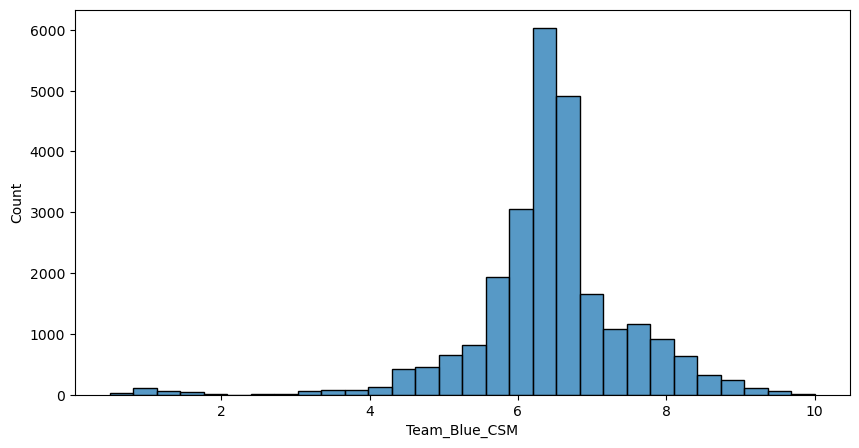

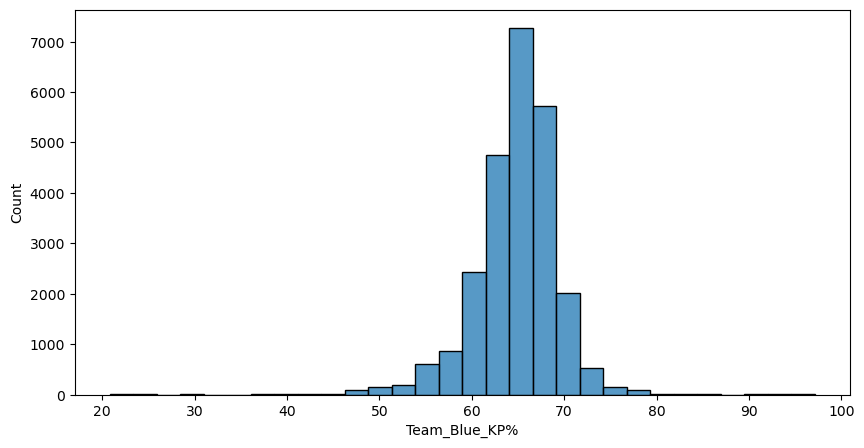

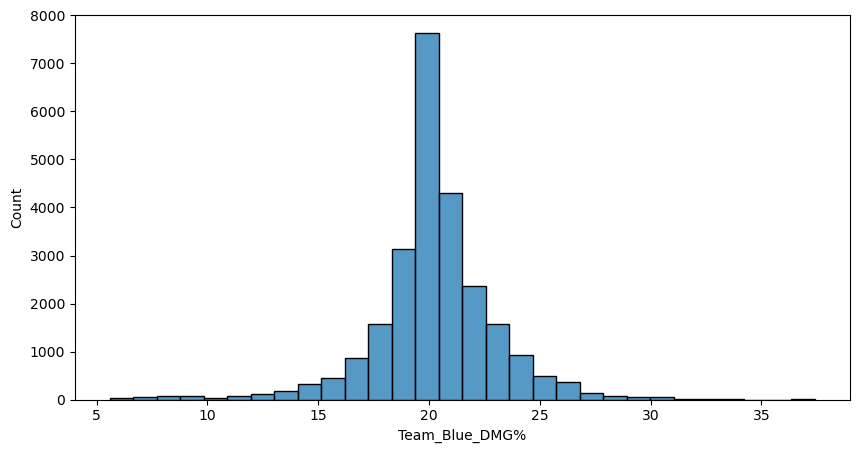

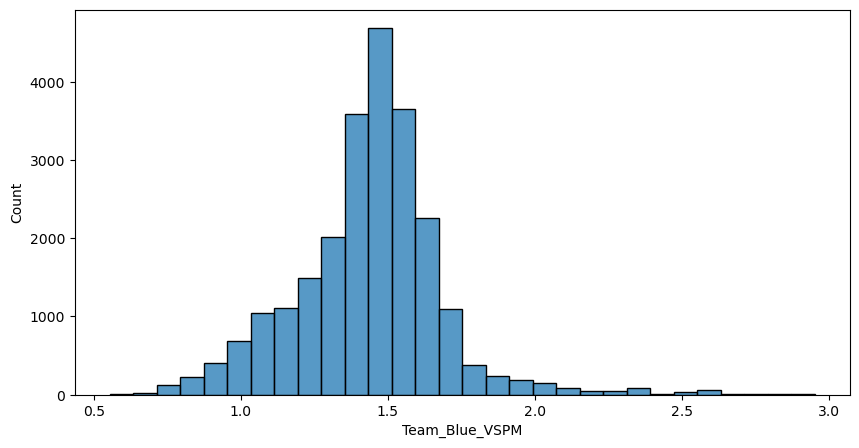

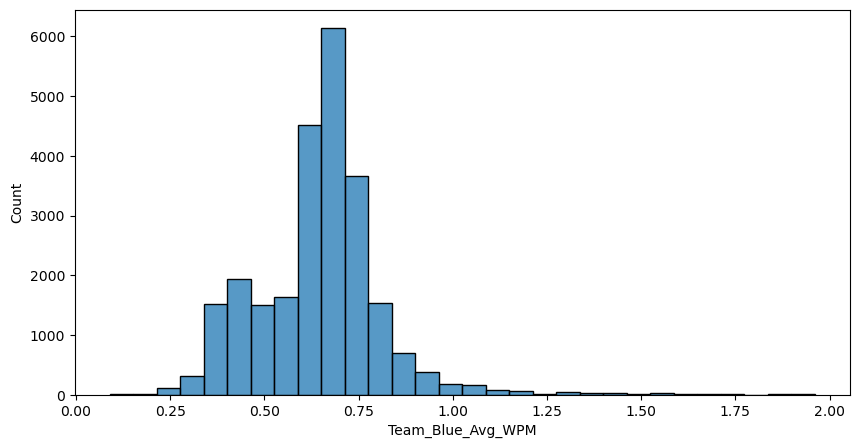

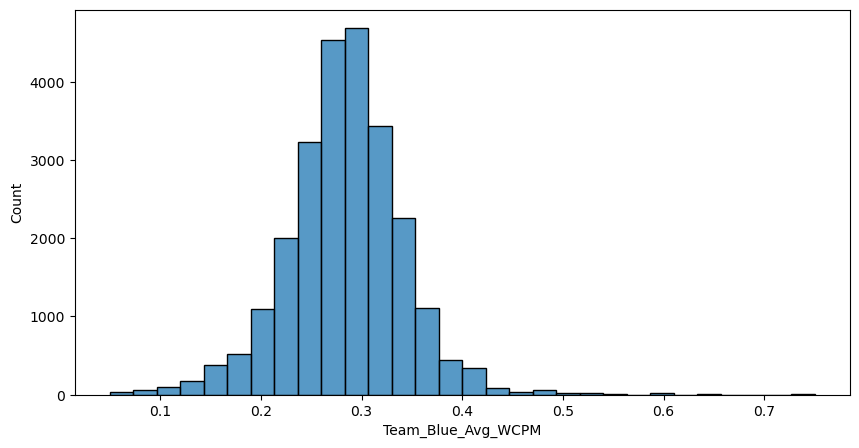

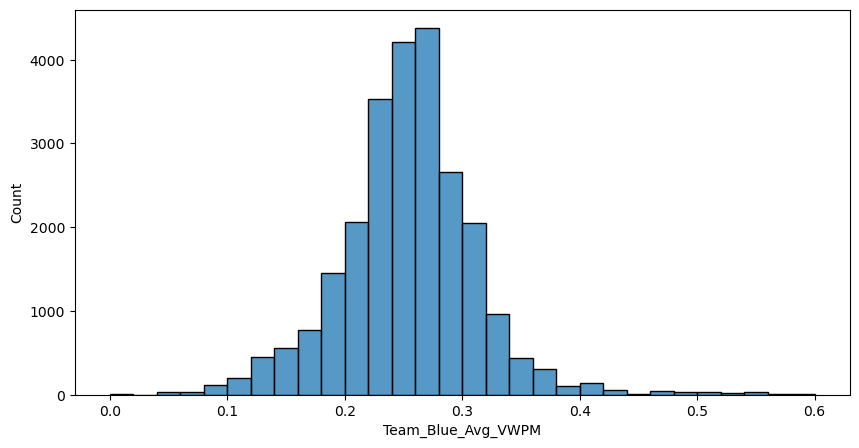

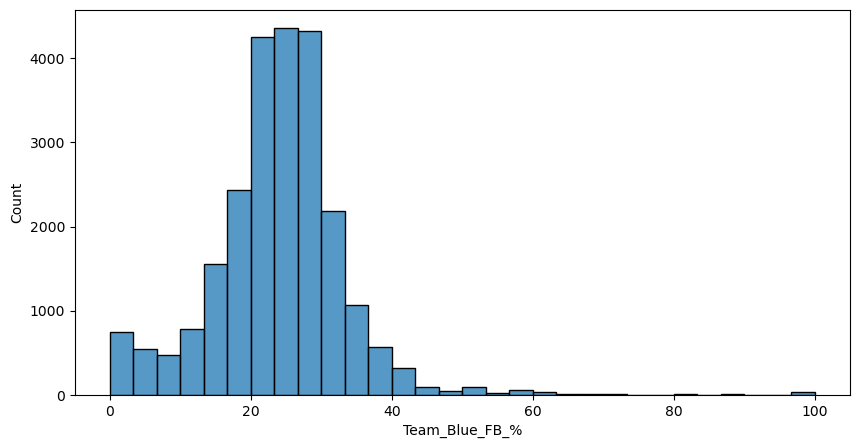

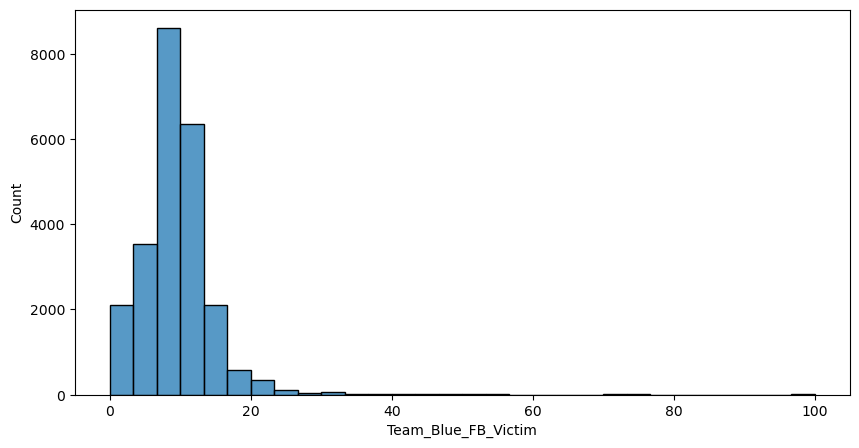

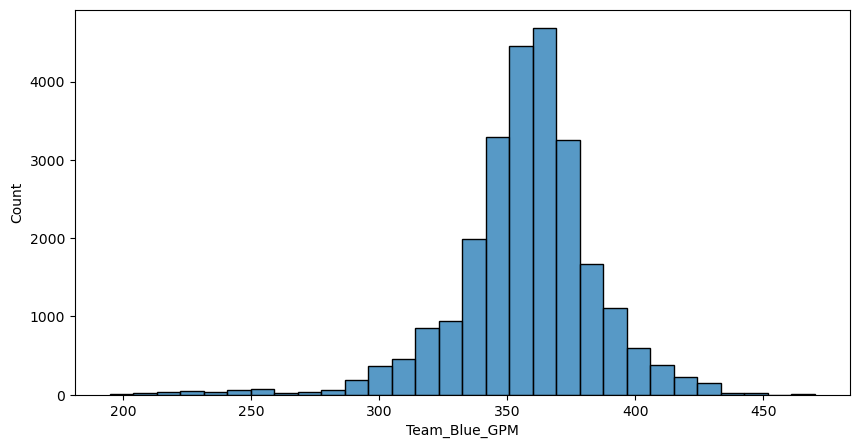

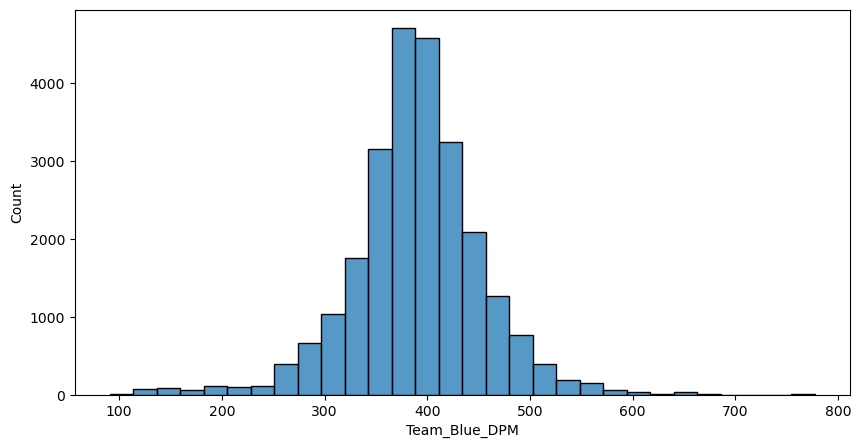

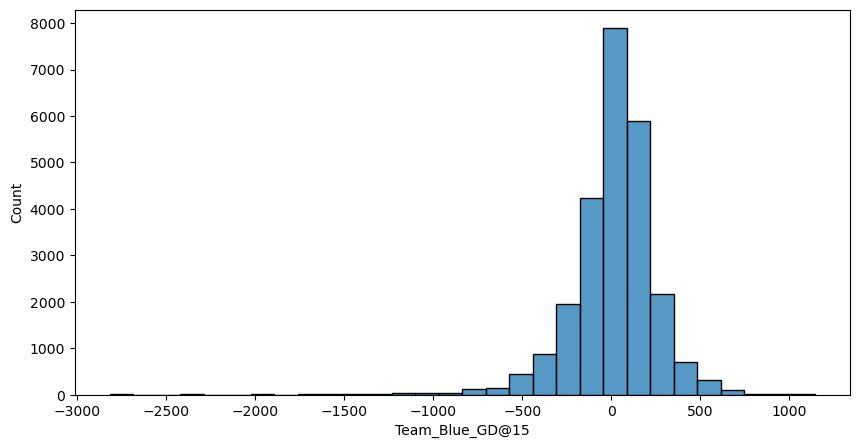

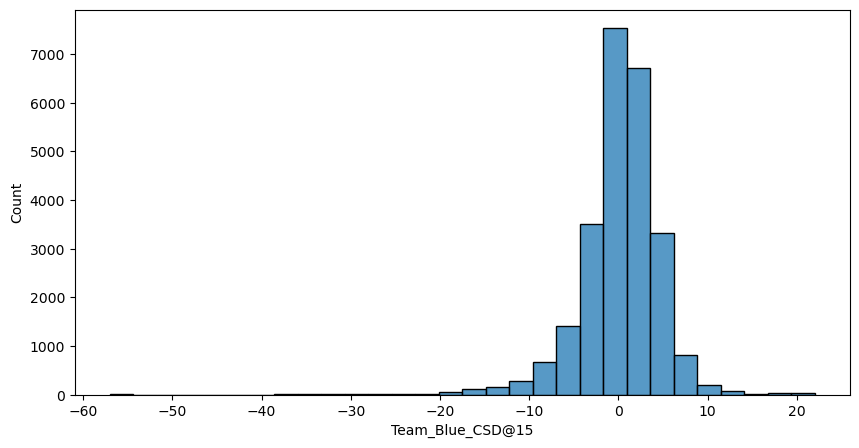

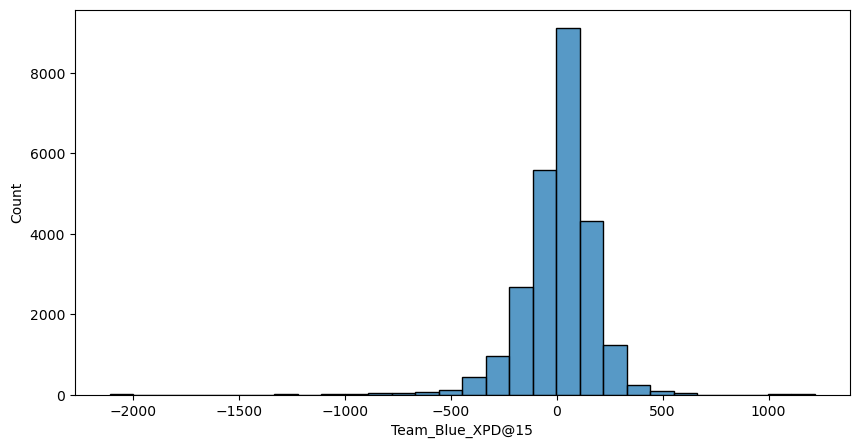

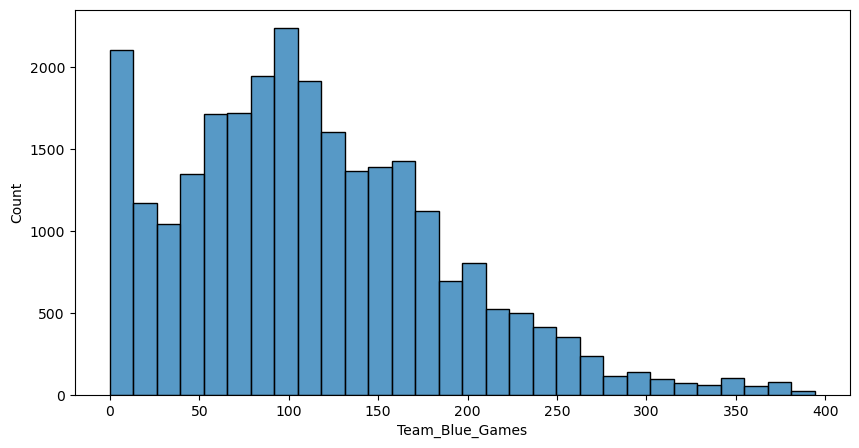

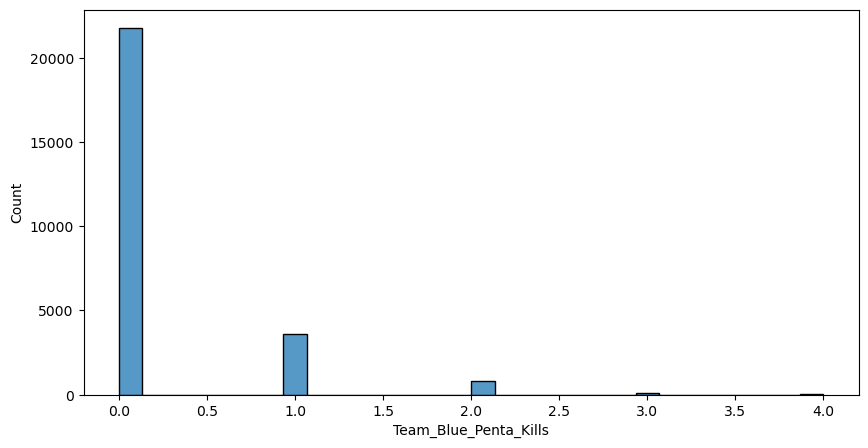

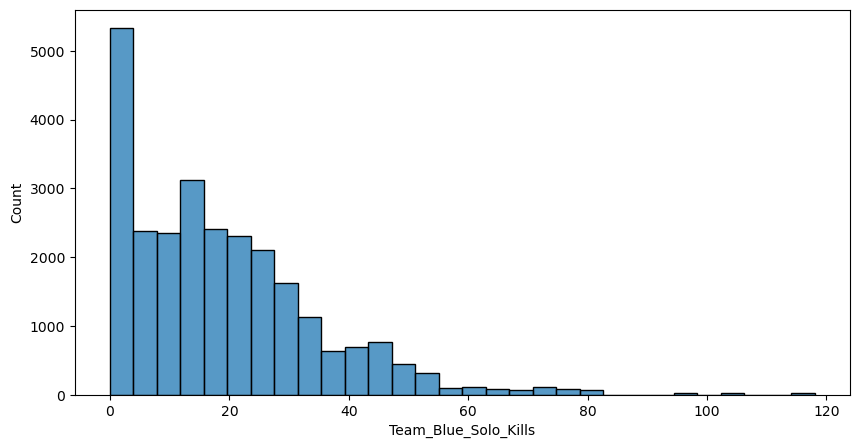

In [13]:
for x in finalBlueFeatures:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=teamMatchList, x=x, bins=30)

<AxesSubplot:>

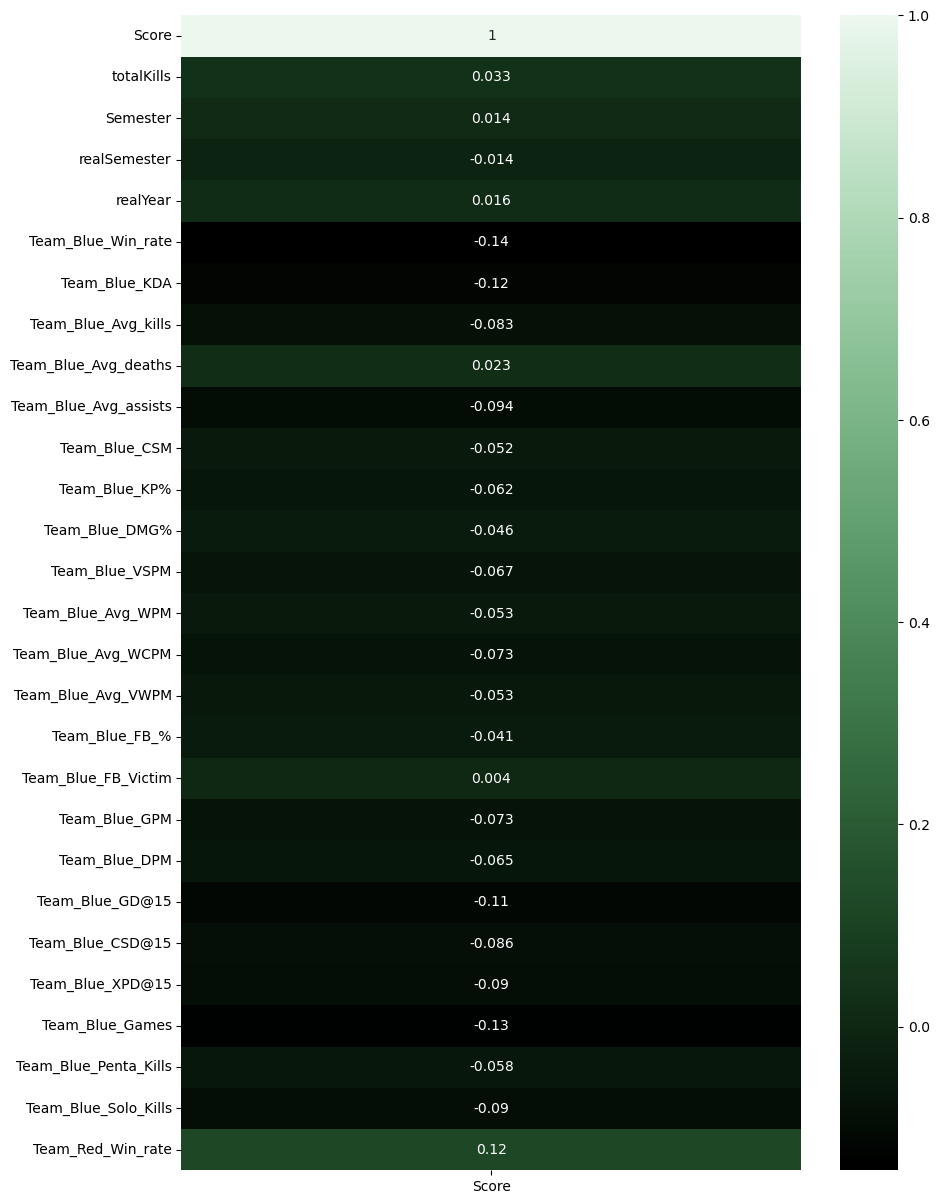

In [14]:
teste = teamMatchList.copy()
for x in teste.columns:
    teste[x] = teste[x].fillna(0)
teste.drop(['Blue','Red','Date','Tournament','matchCode','Split','Year','blueKills','redKills'],axis=1,inplace=True)

greencmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

plt.figure(figsize=(10, 15))
sns.heatmap((teste.corr())[['Score']][:28],cmap=greencmap,annot=True)